<a href="https://colab.research.google.com/github/MilanCugur/DoubledMNIST/blob/master/DoubledMNIST_Classification_Tasks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# General tools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

# Metrics and Evaluation
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import sklearn.metrics as met

# KNearest Neighbours
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier  

# SVC
from sklearn.svm import  SVC
from sklearn.model_selection import validation_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Decision Tree
from sklearn import tree
from sklearn.tree import  DecisionTreeClassifier, export_graphviz
import subprocess
from sklearn.ensemble import RandomForestClassifier

# Deep Neural Network
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPool2D, Flatten, Concatenate, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam  # First, naive approach
from keras.losses import categorical_crossentropy
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger  # Add callbacks to model
from keras.models import load_model  # Save model params
from keras.layers import LeakyReLU, concatenate
from keras.layers.advanced_activations import PReLU
from keras.initializers import glorot_normal
from keras.utils import to_categorical
from keras.utils import Sequence
from sklearn.utils import shuffle
import keras.backend as K

Using TensorFlow backend.


# Load data

In [0]:
def extract_dataset(path):
  """
  extract DoubledMNIST dataset
  Argument: path to .zip file with the dataset
  Return value: x_train, y_train, x_test, y_test lists of numpy arrays 
  
  (DoubledMNIST dataset: train size 120k images 56x56, test size 20k images 56x56)
  """
  # import libraries
  import os                     # for basic os operations
  from zipfile import ZipFile 
  from skimage import io
  import numpy as np
  import shutil
  
  if not path.endswith('.zip'):
    raise ValueError("Error: path is not '.zip' file")
  
  archive = ZipFile(path, 'r')  # extract
  archive.extractall('./DoubledMNIST')
  archive.close()
  del archive
  
  x_train = []
  y_train = []
  x_test = []
  y_test = []
  
  for file in os.listdir('./DoubledMNIST/train'):
    img = io.imread(os.path.join('./DoubledMNIST/train', file))
    x_train.append(np.array(img))
    y_train.append(int(file.split('_')[1]))
  
  for file in os.listdir('./DoubledMNIST/test'):
    img = io.imread(os.path.join('./DoubledMNIST/test', file))
    x_test.append(np.array(img))
    y_test.append(int(file.split('_')[1]))
    
  shutil.rmtree('./DoubledMNIST')
  return x_train, y_train, x_test, y_test

In [4]:
%%time
x_train, y_train, x_test, y_test = extract_dataset('./drive/My Drive/dm_sem/DoubledMNIST.zip')

CPU times: user 54.6 s, sys: 13.4 s, total: 1min 8s
Wall time: 1min 11s


In [5]:
print('No of train images: ', len(x_train))  # size check
print('No of train labels: ', len(y_train))
print('No of test images: ', len(x_test))
print('No of test labels: ', len(y_test))

No of train images:  120000
No of train labels:  120000
No of test images:  20000
No of test labels:  20000


In [6]:
x_train[0]  # image check; its saved as 8bit grayscale image

array([[255, 255, 255, ..., 255, 254, 255],
       [255, 255, 255, ..., 255, 254, 255],
       [255, 255, 255, ..., 255, 254, 255],
       ...,
       [255, 255, 255, ..., 255, 254, 255],
       [254, 254, 254, ..., 254, 254, 254],
       [255, 255, 255, ..., 255, 254, 255]], dtype=uint8)

Slucajni uzorak baze podataka: 


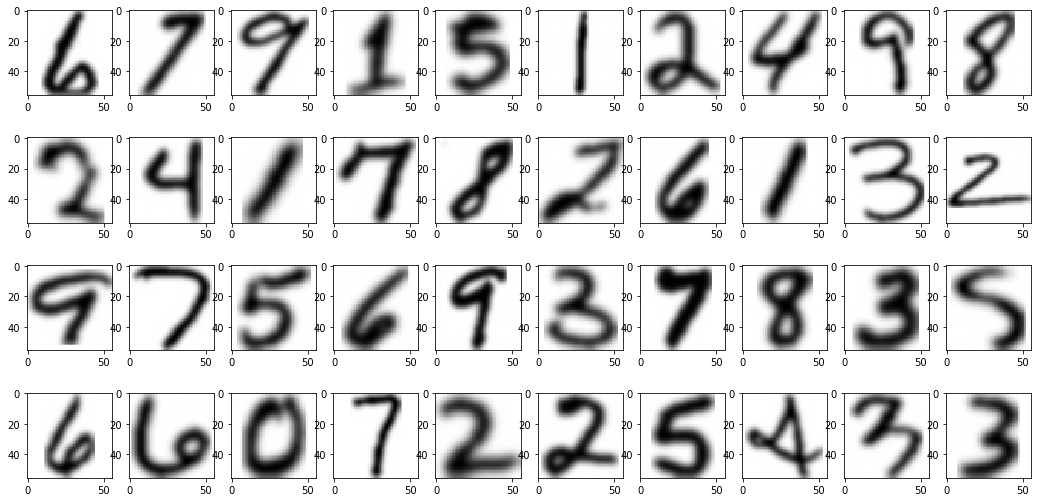

In [57]:
# Plot some examples from datbase
print('Slucajni uzorak baze podataka: ')
fig, ax = plt.subplots(nrows=4, ncols=10)
fig.set_figheight(9)
fig.set_figwidth(18)
for row in ax:
    for col in row:
      i = np.random.randint(len(x_train))
      col.imshow(x_train[i], cmap='gray')
      
plt.show()

In [38]:
x_train[0].shape  # check image shape

(56, 56)

In [39]:
type(x_train[0])  # check image type

numpy.ndarray

# Data for Choosing Parameters / Final Train

In [0]:
# Data for evaluation
x_train_full = np.array([img.flatten()/255.0 for img in x_train])  # image preprocessiong, convert it to [0, 1] and flatten for knn; knn dont requests normalize data?
y_train_full = np.array(y_train)

x_test_full = np.array([img.flatten()/255.0 for img in x_test])
y_test_full = np.array(y_test)

In [0]:
# Data for parameter choosing (knn, svm, dt)
x_train_choose = np.array([img.flatten()/255.0 for img in x_train[:1000]])  
y_train_choose = np.array(y_train[:1000])
x_test_choose = np.array([img.flatten()/255.0 for img in x_train[1000:2000]])  
y_test_choose = np.array(y_train[1000:2000])

Raspodela labela na celom skupu podataka


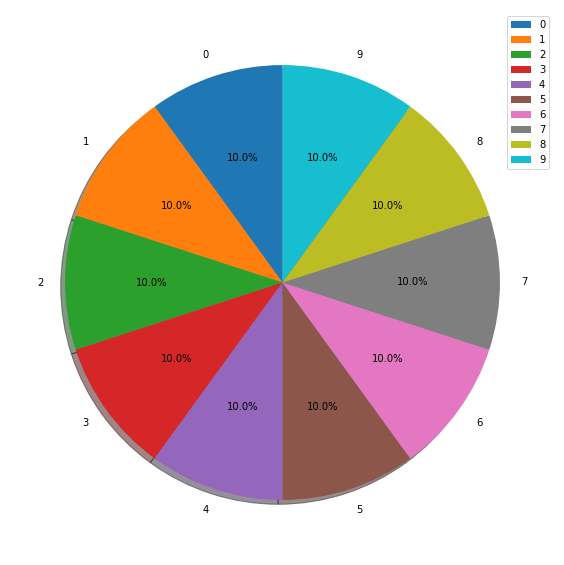

In [55]:
plt.figure(figsize=(10,10))
print('Raspodela labela na celom skupu podataka')
plt.pie([sum(y_train_full==y) for y in range(10)], shadow=True, startangle=90, labels = ['0','1','2','3','4','5','6','7','8','9'], autopct='%1.1f%%')
plt.legend()
plt.show()

Raspodela labela na skupu za izbor parametara


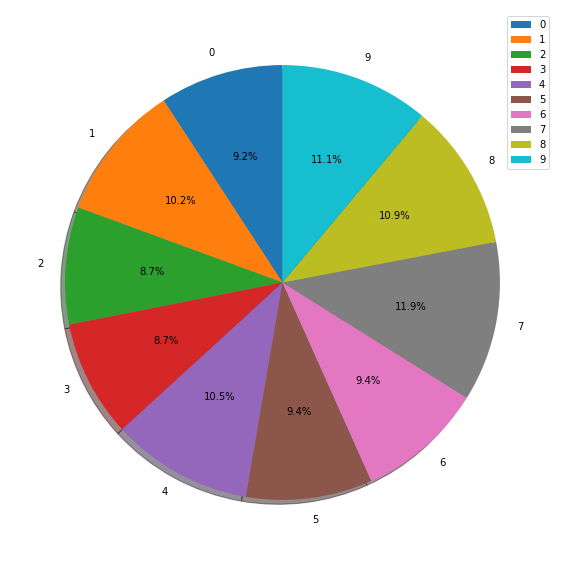

In [56]:
plt.figure(figsize=(10,10))
print('Raspodela labela na skupu za izbor parametara')
plt.pie([sum(y_train_choose==y) for y in range(10)], shadow=True, startangle=90, labels = ['0','1','2','3','4','5','6','7','8','9'], autopct='%1.1f%%')
plt.legend()
plt.show()

In [0]:
labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

# KNearest Neighbours

## Choose parameters

In [69]:
%%time

ks = [1,2,3,4,5,6,7,8,9,10,30]  # choose appropriate k
ps = [1, 2]
ws = ['uniform', 'distance']

max_params = {'k':0, 'p':0, 'w':0}
max_score = 0
for k in ks:
  for p in ps:
    for w in ws:
      knn = KNeighborsClassifier(n_neighbors=k, p=p, weights=w)  # approx ~ 1nn
      knn.fit(x_train_choose, y_train_choose)
  
      score = accuracy_score(y_test_choose, knn.predict(x_test_choose))  # check acc score
      print(f"knn(k={k}, p={p}, weights={w}) : {score}")
      if score>max_score:  # Okamov zilet
        max_params['k'] = k
        max_params['p'] = p
        max_params['w'] = w
        max_score = score
      del knn

knn(k=1, p=1, weights=uniform) : 0.886
knn(k=1, p=1, weights=distance) : 0.886
knn(k=1, p=2, weights=uniform) : 0.904
knn(k=1, p=2, weights=distance) : 0.904
knn(k=2, p=1, weights=uniform) : 0.853
knn(k=2, p=1, weights=distance) : 0.886
knn(k=2, p=2, weights=uniform) : 0.87
knn(k=2, p=2, weights=distance) : 0.904
knn(k=3, p=1, weights=uniform) : 0.874
knn(k=3, p=1, weights=distance) : 0.886
knn(k=3, p=2, weights=uniform) : 0.897
knn(k=3, p=2, weights=distance) : 0.904
knn(k=4, p=1, weights=uniform) : 0.866
knn(k=4, p=1, weights=distance) : 0.889
knn(k=4, p=2, weights=uniform) : 0.891
knn(k=4, p=2, weights=distance) : 0.904
knn(k=5, p=1, weights=uniform) : 0.873
knn(k=5, p=1, weights=distance) : 0.89
knn(k=5, p=2, weights=uniform) : 0.893
knn(k=5, p=2, weights=distance) : 0.898
knn(k=6, p=1, weights=uniform) : 0.872
knn(k=6, p=1, weights=distance) : 0.883
knn(k=6, p=2, weights=uniform) : 0.887
knn(k=6, p=2, weights=distance) : 0.898
knn(k=7, p=1, weights=uniform) : 0.873
knn(k=7, p=1, w

In [70]:
print(max_params)
print(max_score)

{'k': 1, 'p': 2, 'w': 'uniform'}
0.904


## Evaluate on best params

In [0]:
k = max_params['k']
p = max_params['p']
w = max_params['w']

In [100]:
%%time

knn = KNeighborsClassifier(n_neighbors=k, p=p, weights=w)  # approx ~ 1nn
knn.fit(x_train_full, y_train_full)  

CPU times: user 58.6 s, sys: 123 ms, total: 58.8 s
Wall time: 58.6 s


In [0]:
%%time

Mconfusion = np.zeros((10, 10))  # [true, predicted]
y_predicted = []

for i in tqdm(range(len(y_test_full))):
  prediction = knn.predict([x_test_full[i]])[0]
  y_predicted.append(prediction)
  Mconfusion[y_test_full[i], prediction] += 1

 21%|██        | 4206/20000 [41:45<3:00:28,  1.46it/s]

In [0]:
_all = np.sum(np.sum(Mconfusion))
_true = np.sum([Mconfusion[i][i] for i in range(10)])

print('KNN accuracy: ', _true/_all)

In [0]:
report = classification_report(y_test_full, y_predicted)
print(report)

In [0]:
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(Mconfusion, annot=False, ax = ax)

# By definition a confusion matrix C is such that Cij is equal to the number of observations known to be in group i but predicted to be in group j.
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

fig.savefig('KNN_confusion_matrix.png')
plt.show()

# Support Vector Machine (SVC)

In [0]:
print(x_train_choose.shape)
print(y_train_choose.shape)
print(x_test_choose.shape)
print(y_test_choose.shape)

(1000, 3136)
(1000,)
(100, 3136)
(100,)


In [0]:
for i in range(56):  # print values of image!
  for j in range(56):
    print("%.2f " % x_train_choose[0][56*i+j], end='')
  print()

1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 0.99 0.99 0.98 0.98 0.97 0.96 0.94 0.91 0.89 0.86 0.82 0.80 0.78 0.77 0.79 0.81 0.84 0.89 0.92 0.95 0.97 0.98 0.99 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 
1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 0.99 0.99 0.98 0.98 0.98 0.96 0.95 0.94 0.92 0.88 0.85 0.82 0.77 0.75 0.73 0.72 0.74 0.76 0.81 0.86 0.89 0.93 0.96 0.97 0.98 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 
1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 0.99 0.99 0.98 0.98 0.97 0.96 0.95 0.93 0.91 0.89 0.84 0.81 0.77 0.71 0.69 0.67 0.66 0.68 0.71 0.76 0.83 0.87 0.91 0.95 0.96 0.98 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 
1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 1.00 0.99 0.99 0.98 0.97 0.95 0.94 0.92 0.90 0.87 0.84 0.80 0.74 0.

In [0]:
# print basic statistics for any of the 56x56 pixels
data = pd.DataFrame(np.array(x_train_choose).reshape(len(x_train_choose), -1))
data.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,3096,3097,3098,3099,3100,3101,3102,3103,3104,3105,3106,3107,3108,3109,3110,3111,3112,3113,3114,3115,3116,3117,3118,3119,3120,3121,3122,3123,3124,3125,3126,3127,3128,3129,3130,3131,3132,3133,3134,3135
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.999376,0.999169,0.998580,0.998075,0.997259,0.996467,0.995267,0.994145,0.991922,0.990333,0.987639,0.984620,0.981094,0.977376,0.973631,0.969839,0.965729,0.961635,0.957235,0.953125,0.948424,0.943788,0.938584,0.933533,0.928286,0.922714,0.917247,0.912000,0.905792,0.900392,0.895349,0.891537,0.888992,0.888086,0.888776,0.891078,0.894518,0.898847,0.903420,0.908761,...,0.835969,0.821420,0.809133,0.798859,0.789945,0.783776,0.779988,0.779604,0.782318,0.787455,0.796035,0.806271,0.818702,0.831451,0.844608,0.857820,0.870537,0.882698,0.894576,0.905788,0.916439,0.926984,0.936675,0.945165,0.953180,0.960153,0.965427,0.970529,0.974980,0.979737,0.983412,0.986306,0.988702,0.991278,0.992431,0.994655,0.995996,0.996816,0.997761,0.998965
std,0.002654,0.004151,0.006436,0.009676,0.012753,0.015853,0.019160,0.022327,0.026049,0.030777,0.036937,0.043460,0.049943,0.055745,0.060815,0.065382,0.069829,0.074276,0.078356,0.082360,0.085790,0.089262,0.092270,0.095483,0.098363,0.100605,0.102426,0.103938,0.106017,0.108379,0.110813,0.112841,0.113832,0.113726,0.113071,0.111922,0.110174,0.108393,0.106229,0.103851,...,0.202651,0.208225,0.212142,0.215377,0.216909,0.218725,0.219961,0.221028,0.220659,0.219284,0.216524,0.213465,0.209751,0.205084,0.199199,0.191288,0.182025,0.172565,0.163845,0.155492,0.146701,0.137887,0.128685,0.120203,0.110807,0.102824,0.095613,0.088725,0.081877,0.074318,0.066255,0.060821,0.054244,0.045852,0.037778,0.030639,0.024719,0.019305,0.014441,0.013194
min,0.933333,0.894118,0.835294,0.768627,0.717647,0.698039,0.709804,0.749020,0.760784,0.733333,0.713725,0.682353,0.666667,0.666667,0.674510,0.670588,0.670588,0.670588,0.670588,0.666667,0.662745,0.658824,0.658824,0.654902,0.658824,0.658824,0.658824,0.658824,0.662745,0.658824,0.654902,0.654902,0.654902,0.650980,0.643137,0.643137,0.650980,0.654902,0.654902,0.650980,...,0.372549,0.372549,0.368627,0.356863,0.356863,0.352941,0.352941,0.352941,0.356863,0.356863,0.356863,0.356863,0.356863,0.356863,0.356863,0.356863,0.356863,0.356863,0.360784,0.372549,0.372549,0.372549,0.372549,0.372549,0.372549,0.376471,0.380392,0.392157,0.407843,0.392157,0.392157,0.403922,0.419608,0.474510,0.525490,0.552941,0.572549,0.584314,0.615686,0.619608
25%,1.000000,1.000000,1.000000,0.999020,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.992157,0.988235,0.980392,0.972549,0.956863,0.949020,0.937255,0.925490,0.912745,0.894118,0.874510,0.866667,0.857843,0.847059,0.831373,0.815686,0.803922,0.792157,0.796078,0.791176,0.792157,0.792157,0.803922,0.815686,0.827451,0.839216,...,0.677451,0.647059,0.627451,0.603922,0.596078,0.584314,0.580392,0.584314,0.584314,0.596078,0.606863,0.635294,0.658824,0.686275,0.709804,0.743137,0.771569,0.800000,

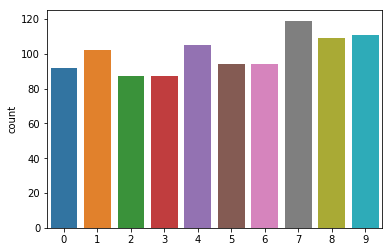

In [0]:
# print concrete sample for parameter choosing
sns.countplot(y_train_choose)

In [0]:
# linear SVC
model_linear = SVC(kernel='linear')
model_linear.fit(x_train_choose, y_train_choose)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [0]:
y_pred_choose = model_linear.predict(x_test_choose)

In [0]:
print("accuracy:", metrics.accuracy_score(y_true=y_test_choose, y_pred=y_pred_choose), "\n")
print(metrics.confusion_matrix(y_true=y_test_choose, y_pred=y_pred_choose))

accuracy: 0.91 

[[ 9  0  0  0  0  0  0  0  0  0]
 [ 0  9  0  0  0  0  0  0  0  0]
 [ 0  0  5  0  0  1  0  0  0  0]
 [ 2  0  0 10  0  0  0  0  0  0]
 [ 0  0  0  0  9  0  1  0  0  0]
 [ 0  2  0  0  0 12  0  0  0  0]
 [ 0  0  0  0  0  1 12  0  0  0]
 [ 0  0  0  0  0  0  0  6  0  1]
 [ 0  1  0  0  0  0  0  0  8  0]
 [ 0  0  0  0  0  0  0  0  0 11]]


In [0]:
# non-linear model
# using rbf kernel, C=1, default value of gamma
non_linear_model = SVC(kernel='rbf')
non_linear_model.fit(x_train_choose, y_train_choose)
y_pred_choose = non_linear_model.predict(x_test_choose)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [0]:
print("accuracy:", metrics.accuracy_score(y_true=y_test_choose, y_pred=y_pred_choose), "\n")
print(metrics.confusion_matrix(y_true=y_test_choose, y_pred=y_pred_choose))

accuracy: 0.93 

[[ 9  0  0  0  0  0  0  0  0  0]
 [ 0  9  0  0  0  0  0  0  0  0]
 [ 0  0  5  0  0  0  0  0  1  0]
 [ 1  0  0 11  0  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 1  1  0  0  0 12  0  0  0  0]
 [ 0  0  0  0  0  0 13  0  0  0]
 [ 0  0  0  0  0  0  0  6  0  1]
 [ 0  1  0  0  0  0  0  0  8  0]
 [ 0  0  0  0  0  0  0  0  1 10]]


In [0]:
# creating a KFold object with 5 splits 
folds = KFold(n_splits = 5, shuffle = True, random_state = 10)
# specify range of hyperparameters
# Set the parameters by cross-validation
hyper_params = [{'gamma': [1e-2, 1e-3, 1e-4], 'C': [5,10]}]
# specify model
model = SVC(kernel="rbf")
model_cv = GridSearchCV(estimator = model, param_grid = hyper_params, scoring= 'accuracy', cv = folds, verbose = 1, return_train_score=True)  
# fit the model
model_cv.fit(x_train_choose, y_train_choose)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  2.7min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=10, shuffle=True),
             error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid=[{'C': [5, 10], 'gamma': [0.01, 0.001, 0.0001]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='accuracy', verbose=1)

In [0]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,4.632373,0.063362,0.583687,0.003300,5,0.01,"{'C': 5, 'gamma': 0.01}",0.905,0.930,0.885,0.930,0.935,0.917,0.019131,1,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,0.000000
1,1.479051,0.019037,0.427787,0.009170,5,0.001,"{'C': 5, 'gamma': 0.001}",0.900,0.935,0.895,0.905,0.915,0.910,0.014142,4,0.98500,0.98750,0.98875,0.98625,0.98375,0.98625,0.001768
2,2.517927,0.165199,0.610589,0.040935,5,0.0001,"{'C': 5, 'gamma': 0.0001}",0.840,0.915,0.830,0.855,0.865,0.861,0.029563,6,0.91125,0.88375,0.89875,0.90250,0.89000,0.89725,0.009598
3,4.731406,0.266706,0.593586,0.040805,10,0.01,"{'C': 10, 'gamma': 0.01}",0.905,0.930,0.885,0.930,0.935,0.917,0.019131,1,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,0.000000
4,1.382461,0.025234,0.409885,0.013182,10,0.001,"{'C': 10, 'gamma': 0.001}",0.920,0.925,0.895,0.900,0.935,0.915,0.015166,3,0.99625,0.99875,1.00000,0.99875,0.99875,0.99850,0.001225
5,2.010562,0.168429,0.532775,0.043830,10,0.0001,"{'C': 10, 'gamma': 0.0001}",0.855,0.925,0.865,0.875,0.880,0.880,0.024083,5,0.93000,0.91625,0.92500,0.92500,0.92500,0.92425,0.004444


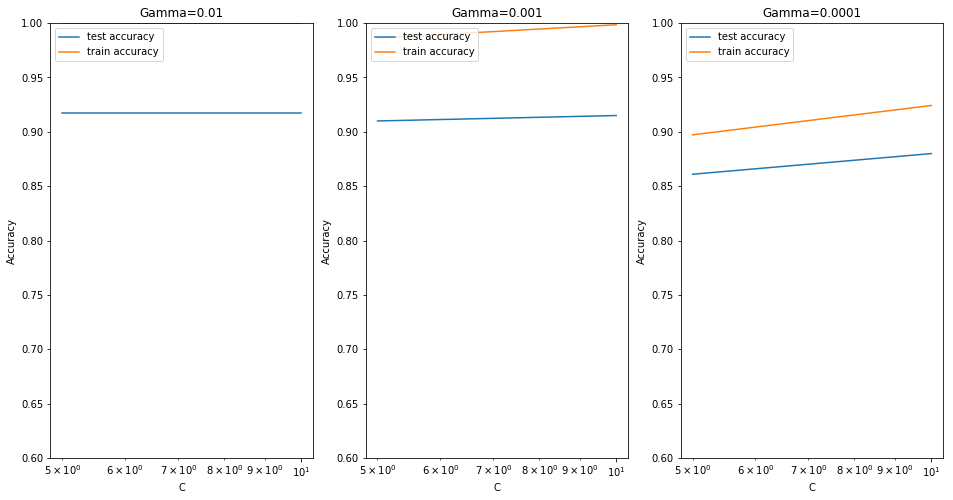

In [0]:
# converting C to numeric type for plotting on x-axis
cv_results['param_C'] = cv_results['param_C'].astype('int')

# # plotting
plt.figure(figsize=(16,8))

# subplot 1/3
plt.subplot(131)
gamma_01 = cv_results[cv_results['param_gamma']==0.01]

plt.plot(gamma_01["param_C"], gamma_01["mean_test_score"])
plt.plot(gamma_01["param_C"], gamma_01["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.01")
plt.ylim([0.60, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

# subplot 2/3
plt.subplot(132)
gamma_001 = cv_results[cv_results['param_gamma']==0.001]

plt.plot(gamma_001["param_C"], gamma_001["mean_test_score"])
plt.plot(gamma_001["param_C"], gamma_001["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.001")
plt.ylim([0.60, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')


# subplot 3/3
plt.subplot(133)
gamma_0001 = cv_results[cv_results['param_gamma']==0.0001]

plt.plot(gamma_0001["param_C"], gamma_0001["mean_test_score"])
plt.plot(gamma_0001["param_C"], gamma_0001["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.0001")
plt.ylim([0.60, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')


In [0]:
best_score = model_cv.best_score_
best_hyperparams = model_cv.best_params_

print("The best test score is {0} corresponding to hyperparameters {1}".format(best_score, best_hyperparams))

The best test score is 0.917 corresponding to hyperparameters {'C': 5, 'gamma': 0.01}


In [0]:
# model
model = SVC(C=5, gamma=0.01, kernel="rbf")

model.fit(x_train_choose, y_train_choose)
y_pred_choose = model.predict(x_test_choose)

# metrics
print("accuracy", metrics.accuracy_score(y_test_choose, y_pred_choose), "\n")
print(metrics.confusion_matrix(y_test_choose, y_pred_choose), "\n")

accuracy 0.95 

[[ 9  0  0  0  0  0  0  0  0  0]
 [ 0  9  0  0  0  0  0  0  0  0]
 [ 0  0  5  0  0  0  0  0  1  0]
 [ 0  0  1 11  0  0  0  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0  0 14  0  0  0  0]
 [ 0  0  1  0  0  1 11  0  0  0]
 [ 0  0  0  0  0  0  0  7  0  0]
 [ 0  1  0  0  0  0  0  0  8  0]
 [ 0  0  0  0  0  0  0  0  0 11]] 



# Decision Tree

## Tree

In [0]:
def visualize_tree(tree, feature_names, class_names):  # Used from Mirjana Maljkovic site
    with open("dt.dot", "w") as f:
        export_graphviz(tree, out_file=f, feature_names=feature_names, class_names=class_names, filled=True, rounded=True)
    f.close()

    subprocess.call("dot -Tpng dt.dot -o tree.png", shell=True)

In [0]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(x_train_choose, y_train_choose)
y_pred_choose = clf.predict(x_test_choose)
print(y_pred_choose[0:20], "...")
print(y_test_choose[0:20], "...")
print(metrics.accuracy_score(y_test_choose, y_pred_choose))

[1 1 6 2 8 0 6 9 2 0 5 4 4 9 0 9 3 4 6 9] ...
[1 3 6 2 8 0 6 9 8 0 5 6 4 9 0 9 3 4 2 9] ...
0.74


In [15]:
%%time

clf = tree.DecisionTreeClassifier()
clf = clf.fit(x_train_full, y_train)
y_pred = clf.predict(x_test_full)
print(y_pred[0:20], ".....")
print(y_test[0:20], ".....")
print(metrics.accuracy_score(y_test, y_pred))

[1 3 6 2 8 0 6 9 8 0 3 6 4 3 0 9 3 4 2 9] .....
[1, 3, 6, 2, 8, 0, 6, 9, 8, 0, 5, 6, 4, 9, 0, 9, 3, 4, 2, 9] .....
0.91385
CPU times: user 13min 19s, sys: 780 ms, total: 13min 20s
Wall time: 13min 20s


## Visualisation

In [0]:
visualize_tree(clf,['pixel '+str((i,j)) for i in range(56) for j in range(56)], ['0','1','2','3','4','5','6','7','8','9'])

In [0]:
len([(i,j) for i in range(56) for j in range(56)])

3136

In [0]:
print('feature (pixel) importances:', '\n')  # Interpretability of decision tree
pd.Series(clf.feature_importances_, index=['pixel '+str((i,j)) for i in range(56) for j in range(56)]).sort_values(ascending=False)

feature (pixel) importances: 



pixel (5, 30)     0.069163
pixel (10, 17)    0.058156
pixel (24, 16)    0.056897
pixel (24, 46)    0.055479
pixel (44, 12)    0.054088
pixel (37, 18)    0.047680
pixel (37, 8)     0.041545
pixel (41, 41)    0.040623
pixel (13, 44)    0.039743
pixel (21, 22)    0.030483
pixel (19, 36)    0.019648
pixel (25, 24)    0.018332
pixel (39, 21)    0.016954
pixel (24, 36)    0.015251
pixel (23, 31)    0.014366
pixel (51, 21)    0.013361
pixel (19, 15)    0.013141
pixel (34, 20)    0.013012
pixel (26, 25)    0.012508
pixel (35, 17)    0.010771
pixel (18, 20)    0.010528
pixel (17, 39)    0.009801
pixel (35, 11)    0.009329
pixel (41, 21)    0.008313
pixel (28, 43)    0.007761
pixel (53, 33)    0.007656
pixel (48, 28)    0.007515
pixel (52, 27)    0.007418
pixel (43, 45)    0.007161
pixel (26, 37)    0.006979
                    ...   
pixel (36, 27)    0.000000
pixel (36, 26)    0.000000
pixel (36, 25)    0.000000
pixel (36, 24)    0.000000
pixel (36, 23)    0.000000
pixel (36, 22)    0.000000
p

## Random forests

In [0]:
clf = RandomForestClassifier(n_estimators=100)

In [33]:
%%time

clf.fit(x_train_full, y_train)

CPU times: user 11min 56s, sys: 102 ms, total: 11min 56s
Wall time: 11min 56s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [36]:
y_pred = clf.predict(x_test_full)
print(y_pred_choose[0:10], "...")
print(y_test_choose[0:10], "...")
print(metrics.accuracy_score(y_test, y_pred))

[1 3 6 2 8 0 6 9 8 0] ...
[1 3 6 2 8 0 6 9 8 0] ...
0.9743


# Deep Neural Network

In [0]:
BOX_SIZE = 56                        
image_shape = (BOX_SIZE, BOX_SIZE, 1)  
labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
number_of_classes = len(labels)        

In [0]:
x_input = Input(shape=image_shape)  

x = Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation='relu', padding='valid')(x_input)
x = Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation='relu', padding='valid')(x) 
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2,2), padding='valid')(x)                                                      
x = Conv2D(filters=48, kernel_size=(3,3), strides=(1,1), activation='relu', padding='valid')(x)        
x = Conv2D(filters=48, kernel_size=(3,3), strides=(1,1), activation='relu', padding='valid')(x) 
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2,2), padding='valid')(x)                                                      
x = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation='relu', padding='valid')(x)        
x = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), activation='relu', padding='valid')(x) 
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(3, 3), padding='valid')(x)                                                    
x = Flatten()(x)                                                                                       

x = Dense(units=768, activation='relu')(x)         
x = Dropout(rate=0.25)(x)                          
x = Dense(units=256, name='next_to_last')(x)                           
x = Dropout(rate=0.25)(x)                          

y_output = Dense(units=number_of_classes, activation='softmax')(x)  

In [0]:
recognizer = Model(inputs=x_input, outputs=y_output, name='recognizer')

In [0]:
recognizer.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 56, 56, 1)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 54, 54, 32)        320       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 52, 52, 32)        9248      
_________________________________________________________________
batch_normalization_7 (Batch (None, 52, 52, 32)        128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 24, 24, 48)        13872     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 22, 22, 48)        20784     
__________

In [0]:
recognizer.compile(optimizer=Adam(lr=1e-3), loss=categorical_crossentropy, metrics=['accuracy'])   # beta_1=0.9, beta_2=0.999

In [0]:
reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, verbose=1, mode='min', #add min_delta
                           cooldown=1, min_le=1e-8)

estop = EarlyStopping(monitor='val_loss', min_delta=0, patience=4, verbose=1, mode='min')

excel = CSVLogger(filename='./CNN.csv', separator=',', append=False)

checkp = ModelCheckpoint('./CNN_weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)

In [0]:
class SequenceGenerator(Sequence):
  # infodisk - [(path, label, writer)]
  # batch_size - size of batch
  
    def __init__(self, xs, ys, batch_size):
      self.xs = np.array(xs)
      self.ys = np.array(ys)
      self.batch_size = batch_size
    
    def __len__(self):
      return int(np.ceil(len(self.xs)/float(self.batch_size)))
  
    def __getitem__(self, index):
      _xs = self.xs[index*self.batch_size: (index+1)*self.batch_size]
      _ys = self.ys[index*self.batch_size: (index+1)*self.batch_size]
    
      return np.array([(x.reshape(BOX_SIZE, BOX_SIZE, 1))/255.0 for x in _xs]), to_categorical(_ys, number_of_classes)
  
    def on_epoch_end(self):
      self.xs, self.ys = shuffle(self.xs, self.ys)

In [0]:
test = SequenceGenerator(x_train, y_train, 50)
x, y = test.__getitem__(0)
print(x.shape)
print(y.shape)

(50, 56, 56, 1)
(50, 10)


In [0]:
np.array(x_train).shape

(120000, 56, 56)

In [0]:
train_generator = SequenceGenerator(x_train[:100_000], y_train[:100_000], 1000)
validation_generator = SequenceGenerator(x_train[100_000:], y_train[100_000:], 1000)

In [0]:
history = recognizer.fit_generator(generator=train_generator, epochs=10, verbose=1,
                                   use_multiprocessing=False, workers=2, validation_data=validation_generator,
                                   callbacks=[reduce, estop, excel, checkp])

Epoch 1/10
100/100 [==============================] - 23s 228ms/step - loss: 0.0159 - acc: 0.9952 - val_loss: 0.0277 - val_acc: 0.9921

Epoch 00001: val_loss improved from 0.03119 to 0.02772, saving model to ./CNN_weights.h5
Epoch 2/10
100/100 [==============================] - 23s 231ms/step - loss: 0.0146 - acc: 0.9955 - val_loss: 0.0372 - val_acc: 0.9887

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00002: val_loss did not improve from 0.02772
Epoch 3/10
100/100 [==============================] - 23s 226ms/step - loss: 0.0100 - acc: 0.9971 - val_loss: 0.0233 - val_acc: 0.9929

Epoch 00003: val_loss improved from 0.02772 to 0.02334, saving model to ./CNN_weights.h5
Epoch 4/10
100/100 [==============================] - 22s 225ms/step - loss: 0.0083 - acc: 0.9977 - val_loss: 0.0226 - val_acc: 0.9933

Epoch 00004: val_loss improved from 0.02334 to 0.02256, saving model to ./CNN_weights.h5
Epoch 5/10
100/100 [==============================] - 23s

In [0]:
recognizer.evaluate(x=(np.array(x_test)/255.0).reshape(len(x_test), BOX_SIZE, BOX_SIZE, 1), y=to_categorical(np.array(y_test), number_of_classes), batch_size=256, verbose=1)

20000/20000 [==============================] - 2s 96us/step


[0.025394510033074767, 0.9937]

In [0]:
recognizer.save_weights('./CNN_weights.h5') 
recognizer.save('./CNN_model.h5') 

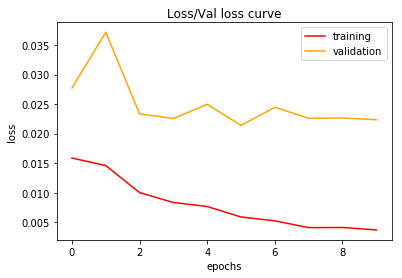

In [0]:
epochs = history.epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.title('Loss/Val loss curve')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(epochs, loss, color='red', label='training')
plt.plot(epochs, val_loss, color='orange', label='validation')
plt.legend()
plt.show()

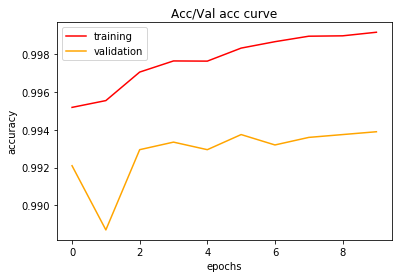

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']

plt.title('Acc/Val acc curve')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.plot(epochs, acc, color='red', label='training')
plt.plot(epochs, val_acc, color='orange', label='validation')
plt.legend()
plt.show()

In [0]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

y_predicted = np.argmax(recognizer.predict((np.array(x_test)/255.0).reshape(len(x_test), BOX_SIZE, BOX_SIZE, 1)), axis=1)
print('predicted: ', y_predicted[0:5])
print('test: ', y_test[0:5])
acc = accuracy_score(y_test, y_predicted)
print(acc*100.0)
report = classification_report(y_test, y_predicted)
print(report)

predicted:  [1 3 6 2 8]
test:  [1, 3, 6, 2, 8]
99.37
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2000
           1       0.99      1.00      0.99      2000
           2       0.99      0.99      0.99      2000
           3       1.00      0.99      0.99      2000
           4       0.99      0.99      0.99      2000
           5       1.00      1.00      1.00      2000
           6       1.00      0.99      1.00      2000
           7       0.99      0.99      0.99      2000
           8       0.99      0.99      0.99      2000
           9       0.99      0.99      0.99      2000

    accuracy                           0.99     20000
   macro avg       0.99      0.99      0.99     20000
weighted avg       0.99      0.99      0.99     20000



In [0]:
from sklearn.metrics import confusion_matrix

M = confusion_matrix(y_test, y_predicted)
display(M)
recall = np.diag(M) / np.sum(M, axis = 1)
print(recall)
precision = np.diag(M) / np.sum(M, axis = 0)
print(precision)

array([[1994,    0,    2,    0,    1,    1,    1,    0,    0,    1],
       [   0, 1992,    6,    0,    0,    0,    0,    2,    0,    0],
       [   2,    1, 1987,    1,    0,    0,    1,    2,    5,    1],
       [   0,    0,    7, 1983,    0,    4,    0,    3,    3,    0],
       [   1,    1,    0,    0, 1985,    0,    2,    2,    1,    8],
       [   0,    0,    1,    4,    1, 1991,    0,    0,    2,    1],
       [   3,    3,    0,    0,    0,    2, 1989,    0,    3,    0],
       [   0,    7,    5,    0,    4,    0,    0, 1983,    0,    1],
       [   1,    1,    3,    0,    3,    2,    1,    0, 1985,    4],
       [   3,    0,    0,    0,    5,    0,    0,    3,    4, 1985]])

[0.997  0.996  0.9935 0.9915 0.9925 0.9955 0.9945 0.9915 0.9925 0.9925]
[0.99500998 0.99351621 0.98806564 0.99748491 0.9929965  0.9955
 0.99749248 0.99398496 0.99101348 0.992004  ]


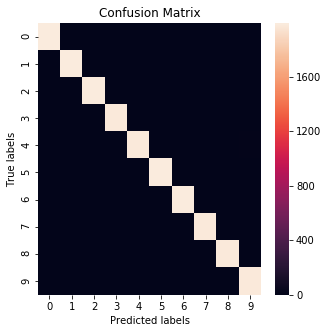

In [0]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(M, annot=False, ax = ax)

# By definition a confusion matrix C is such that Cij is equal to the number of observations known to be in group i but predicted to be in group j.
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

fig.savefig('confusion_matrix.png')
plt.show()

In [0]:
# Manually print confusion matrix
print('  ', end='  ')
print('0    ', end='')
for j in labels[1:]:
    print(str(j), end='   ')
print()
for idx, i in enumerate(M):
    print(str(labels[idx]), end=' ')
    for j in i:
        print('%3d' % (j), end=' ')
    print()

    0    1   2   3   4   5   6   7   8   9   
0 1994   0   2   0   1   1   1   0   0   1 
1   0 1992   6   0   0   0   0   2   0   0 
2   2   1 1987   1   0   0   1   2   5   1 
3   0   0   7 1983   0   4   0   3   3   0 
4   1   1   0   0 1985   0   2   2   1   8 
5   0   0   1   4   1 1991   0   0   2   1 
6   3   3   0   0   0   2 1989   0   3   0 
7   0   7   5   0   4   0   0 1983   0   1 
8   1   1   3   0   3   2   1   0 1985   4 
9   3   0   0   0   5   0   0   3   4 1985 


true label:  1
predicted label:  2


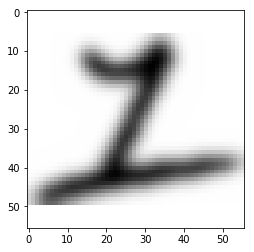

true label:  2
predicted label:  8


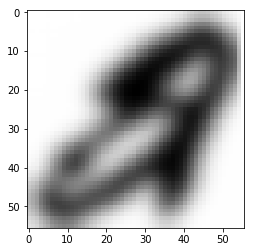

true label:  5
predicted label:  4


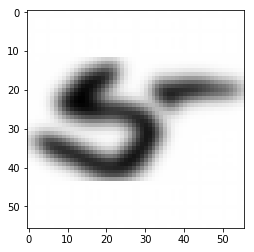

true label:  7
predicted label:  2


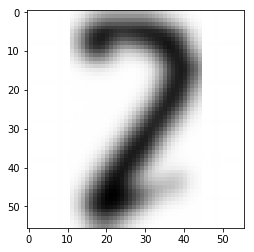

true label:  8
predicted label:  4


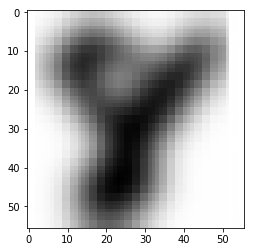

true label:  8
predicted label:  2


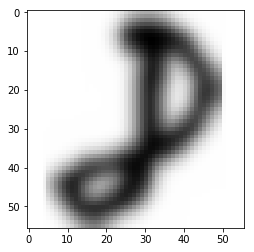

true label:  2
predicted label:  7


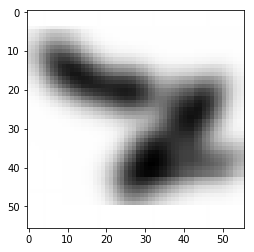

true label:  6
predicted label:  5


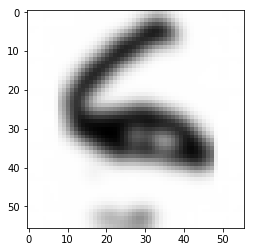

true label:  5
predicted label:  3


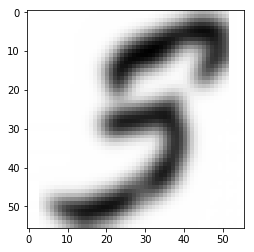

true label:  8
predicted label:  6


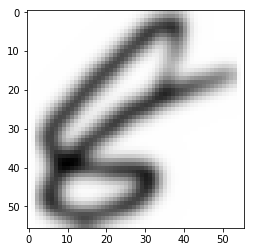

In [0]:
# Visualise missclassified examples 
indexes = y_test!=y_predicted
n = sum(indexes)  # 126
x_test_wrong = np.array(x_test)[indexes]
y_test_wrong = np.array(y_test)[indexes]
y_predicted_wrong = np.array(y_predicted)[indexes]
for i in range(10):
  print('true label: ', y_test_wrong[i])
  print('predicted label: ', y_predicted_wrong[i])
  plt.imshow(x_test_wrong[i], cmap='gray')
  plt.show()